# **CNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [78]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/NotAveragePooled/split_features_2s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [79]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [80]:
# train_data]

In [81]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [82]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [83]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [84]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [85]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [86]:
# display(train_y.shape)
# display(train_y[:15])

In [87]:
# for key in train_features.keys():
#   display(key)
#   display(train_features[key].shape)
#   display(train_features[key][0])

In [88]:
# display(val_y.shape)
# display(val_y[:15])

In [89]:
# for key in val_features.keys():
#   display(key)
#   display(val_features[key].shape)
#   display(val_features[key][0])

## **CNN Model**

In [90]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2],audio_features.shape[3]), name='Audio_Features')

  # add first convolution layer to the model
  features = tf.keras.layers.Conv2D(
              filters=64,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(inputs)

  # add first max pooling layer
  # features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1')(features)
  # add second convolution layer to the model
  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)
  # features = tf.keras.layers.BatchNormalization()(features)
  # add third max pooling layer
  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2')(features)

  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_3',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)
  features = tf.keras.layers.BatchNormalization()(features)
  # add second max pooling layer
  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_3')(features)



  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=512,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.5)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [91]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [92]:
train_results = {}
val_results = {}

### **With all the features**

In [93]:
n_time = train_features['melspectrogram'].shape[2]

mfcc_tiled = np.tile(train_features['mfcc'], (1, 3, 1))  # (3318, 60, 44), tiling 3 times to match 60 features
chroma_tiled = np.tile(train_features['chroma'], (1, 5, 1))  # (3318, 60, 44), tiling 5 times to match 60 features
rms_tiled = np.tile(train_features['rms'], (1, 60, 1))  # (3318, 60, 44), tiling 60 times to match 60 features

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, rms_tiled), axis=-1)

print(training_features.shape)

(22631, 60, 87, 4)


In [94]:
mfcc_val_tiled = np.tile(val_features['mfcc'], (1, 3, 1))  # Tile to (n_samples_val, 60, 44)
chroma_val_tiled = np.tile(val_features['chroma'], (1, 5, 1))  # Tile to (n_samples_val, 60, 44)
rms_val_tiled = np.tile(val_features['rms'], (1, 60, 1))  # Tile to (n_samples_val, 60, 44)

melspectrogram_val = val_features['melspectrogram']

validation_features = np.stack((melspectrogram_val, mfcc_val_tiled, chroma_val_tiled, rms_val_tiled), axis=-1)

print(validation_features.shape)

(6044, 60, 87, 4)


Fit the model with training data

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 60, 87, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 60, 87, 64)          │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 30, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 30, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 15, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 15, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 7, 10, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2240)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       1,147,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,241,108 (4.73 MB)

 Trainable params: 1,241,044 (4.73 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.2023 - loss: 12.9300 - weighted_accuracy: 0.2023 - val_accuracy: 0.3769 - val_loss: 7.7599 - val_weighted_accuracy: 0.3769
Epoch 2/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4014 - loss: 6.8243 - weighted_accuracy: 0.4014 - val_accuracy: 0.4485 - val_loss: 5.0967 - val_weighted_accuracy: 0.4485
Epoch 3/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4859 - loss: 4.5569 - weighted_accuracy: 0.4859 - val_accuracy: 0.4313 - val_loss: 4.0411 - val_weighted_accuracy: 0.4313
Epoch 4/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5421 - loss: 3.4465 - weighted_accuracy: 0.5421 - val_accuracy: 0.4207 - val_loss: 3.5546 - val_weighted_accuracy: 0.4207
Epoch 5/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5866 - loss: 2.7969 - weighted_accuracy: 0.5866 - val_accuracy: 0.4193 - val_loss: 3.1070 - val_weighted_accuracy: 0.4193
Epoch 6/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s

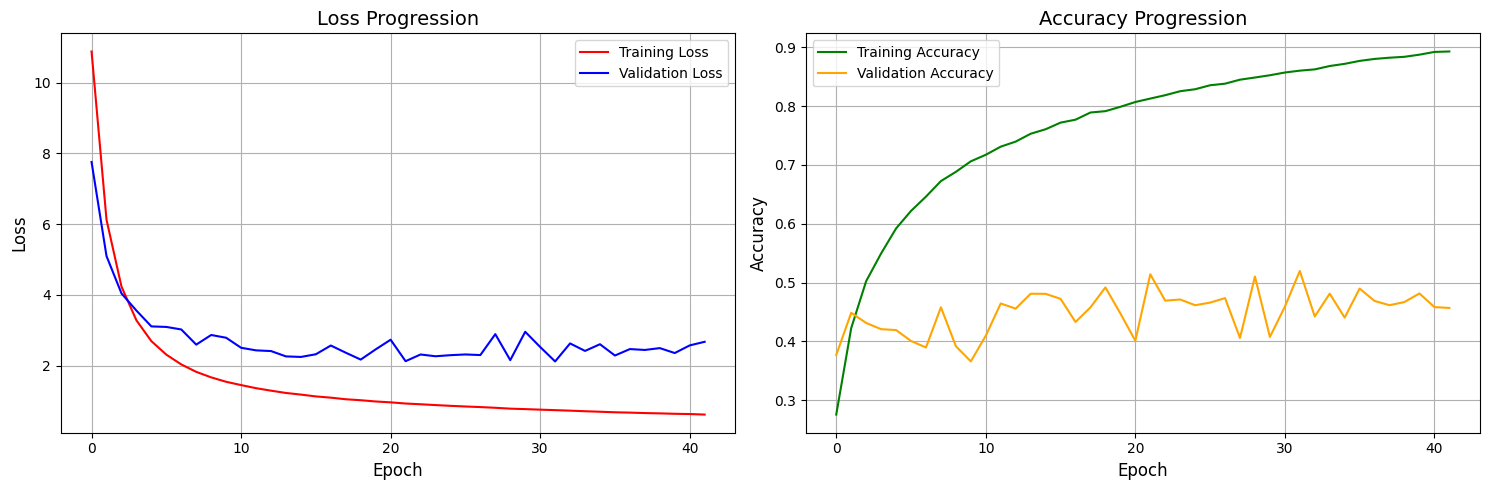

In [95]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [96]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9161 - loss: 0.6033 - weighted_accuracy: 0.9161
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5242 - loss: 2.0918 - weighted_accuracy: 0.5242


## **With Mel-Spectrogram, MFCCs, Chroma**

In [97]:
n_time = train_features['melspectrogram'].shape[2]

mfcc_tiled = np.tile(train_features['mfcc'], (1, 3, 1))  # (3318, 60, 44), tiling 3 times to match 60 features
chroma_tiled = np.tile(train_features['chroma'], (1, 5, 1))  # (3318, 60, 44), tiling 5 times to match 60 features
rms_tiled = np.tile(train_features['rms'], (1, 60, 1))  # (3318, 60, 44), tiling 60 times to match 60 features

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, rms_tiled), axis=-1)

print(training_features.shape)

(22631, 60, 87, 4)


In [98]:
mfcc_val_tiled = np.tile(val_features['mfcc'], (1, 3, 1))  # Tile to (n_samples_val, 60, 44)
chroma_val_tiled = np.tile(val_features['chroma'], (1, 5, 1))  # Tile to (n_samples_val, 60, 44)
rms_val_tiled = np.tile(val_features['rms'], (1, 60, 1))  # Tile to (n_samples_val, 60, 44)

melspectrogram_val = val_features['melspectrogram']

validation_features = np.stack((melspectrogram_val, mfcc_val_tiled, chroma_val_tiled, rms_val_tiled), axis=-1)

print(validation_features.shape)

(6044, 60, 87, 4)


Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 60, 87, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 60, 87, 64)          │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 30, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 30, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 15, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 15, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 7, 10, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2240)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       1,147,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,241,108 (4.73 MB)

 Trainable params: 1,241,044 (4.73 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.2023 - loss: 12.8026 - weighted_accuracy: 0.2023 - val_accuracy: 0.3190 - val_loss: 7.7328 - val_weighted_accuracy: 0.3190
Epoch 2/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4033 - loss: 6.6292 - weighted_accuracy: 0.4033 - val_accuracy: 0.3633 - val_loss: 5.0994 - val_weighted_accuracy: 0.3633
Epoch 3/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4892 - loss: 4.3748 - weighted_accuracy: 0.4892 - val_accuracy: 0.4199 - val_loss: 3.9915 - val_weighted_accuracy: 0.4199
Epoch 4/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5472 - loss: 3.2966 - weighted_accuracy: 0.5472 - val_accuracy: 0.3810 - val_loss: 3.4808 - val_weighted_accuracy: 0.3810
Epoch 5/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5935 - loss: 2.6717 - weighted_accuracy: 0.5935 - val_accuracy: 0.4385 - val_loss: 3.0957 - val_weighted_accuracy: 0.4385
Epoch 6/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s

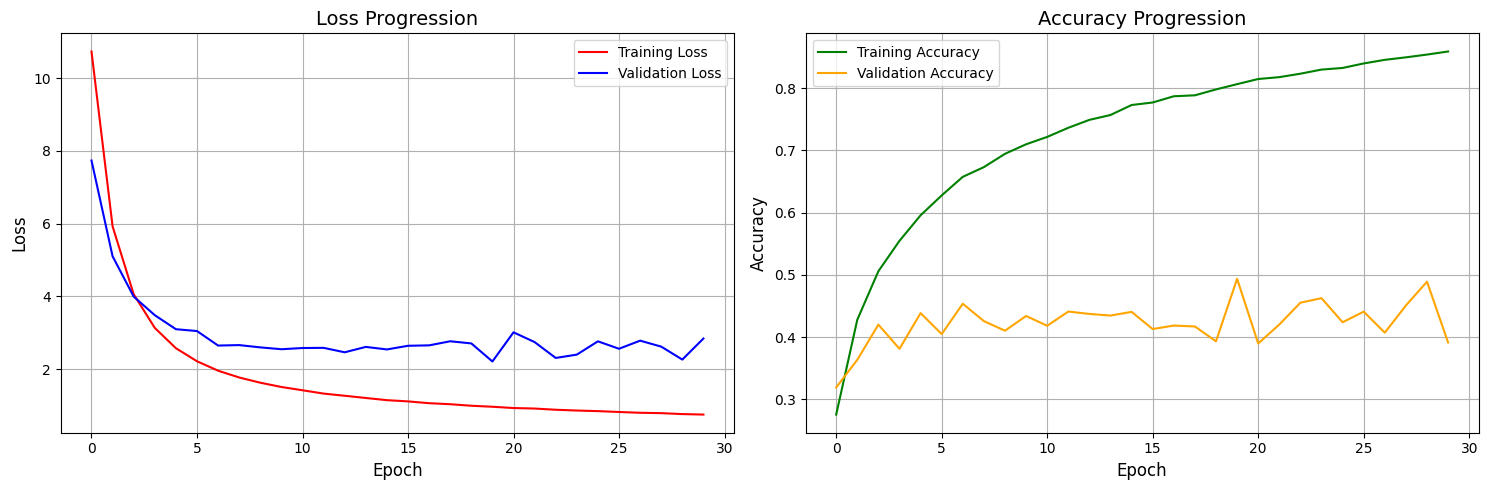

In [99]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [100]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8720 - loss: 0.7985 - weighted_accuracy: 0.8720
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4986 - loss: 2.1868 - weighted_accuracy: 0.4986


# Review results from all models

In [101]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.914,0.520
1,melspectrogram_chroma_mfcc,0.870,0.494
